In [1]:
# load necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import pickle
import glob

from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (10, 10)

## Specify file and folder locations

In [2]:
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"
clFile = 'data/letter-slope-classifications_10nov2017.csv'
savefile = "character_seg.pkl"

consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
# consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
consensusCsvFiles = glob.glob('{}/*.csv'.format(consensusFolder))
consensusCsvFiles = [i for i in consensusCsvFiles if "linewise" in i]

## Segmentation of words

In [3]:
def matchLines(lb, actuallb, yoffset, matchlim = 30):
    matches = []
    lb2 = np.add(lb, yoffset)
    for i in range(len(lb)):
        closest = np.argmin(np.abs(np.subtract(lb2[i], actuallb)))
        if np.abs(lb2[i] - actuallb[closest]) < matchlim:
            matches.append(closest)
        else:
            matches.append(-1)
    return matches

def wordBreaks(grey, lb, matches, linesForTele, nu=3.5, bi=2):
    accurL = []

    for i in range(1, len(lb)):
        print(i, end=" ")
        if matches[i] == -1:
            continue
        chunk = grey[lb[i-1]:lb[i],]
        rw = linesForTele.loc[matches[i],"consensus_text"]
        # remove leading and trailing "
        if rw[0] == '"':
            rw = rw[1:]
        if rw[-1] == '"':
            rw = rw[:-1]
        br = gaussBreaks(chunk, nu=nu, biThresh=bi, shear=0, fix=0)
        accurL.append({"lb_index":i, "consensus":rw, "breaks":br})
    return pd.DataFrame(accurL)

In [4]:
# run this to only do one file
consensusCsvFiles = [consensusCsvFiles[0]]

In [5]:
# subject file
subj = readSubjFile(subjFile)
# classification export
clExp = readSlopeClassification(clFile)


data = {}
# for consensusFile in consensusCsvFiles:
consensusFile = consensusCsvFiles[0]
#################################################################################
# Read data files
# consensus file (by line)
cons = readConsensusFile(consensusFile)
# combine data files
idAndUrl, telegrams = mergeSubjAndCons(subj, cons, clExp)

In [6]:
##############################################################################################
# collect the data for the wordbreaks

#     for im in list(idAndUrl.index):
im = list(idAndUrl.index)[0]
hdl_id = idAndUrl.loc[im, "hdl_id"]
data[hdl_id] = {}
print(hdl_id)

data[hdl_id]["url"] = idAndUrl.loc[im, "url_cons"]
linesForTele = telegrams.loc[telegrams["hdl_id"] == hdl_id]
linesForTele.loc[:,"y1"] = [np.mean(eval(l))
                            for l in linesForTele.loc[:,"y_loc"]]

# read in and do all pre-processing #################################
let_orig, grey_orig = readImg(idAndUrl.loc[im, "url_cons"])
grey, let, offset = removeEdges(grey_orig, let_orig, 35.0)
greySm = smoothImg(grey, 7.0)

# get linebreaks ####################################################
matchlim = 30
lb = projBreaks(greySm, "y")
lb = filterBreaks(lb, matchlim)
data[hdl_id]["lb"] = lb

# get matching lines with actual lines ##############################
actuallb = linesForTele.loc[:, 'y1']
data[hdl_id]['trim_offset'] = offset
matches = matchLines(lb, actuallb, offset[0])
data[hdl_id]["matches"] = matches

# get wordbreaks ####################################################
accur = wordBreaks(grey, lb, matches, linesForTele)
data[hdl_id]["word_segments"] = accur
print()

# get slope from classification export
slope = meanSlope(clExp, hdl_id)

mssEC_02_007
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 


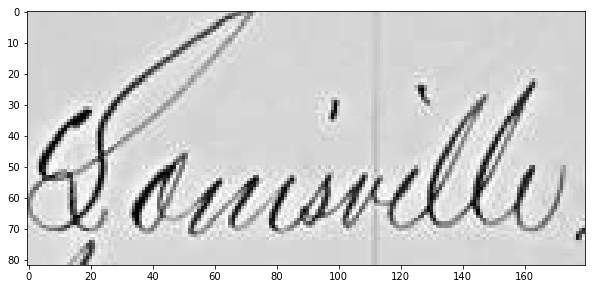

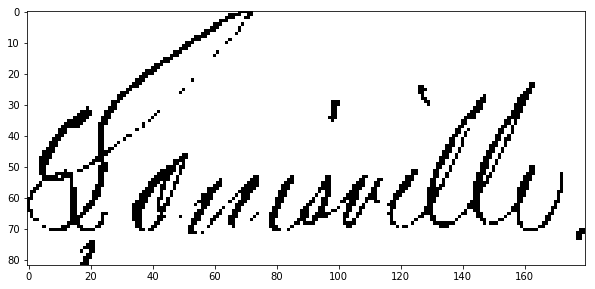

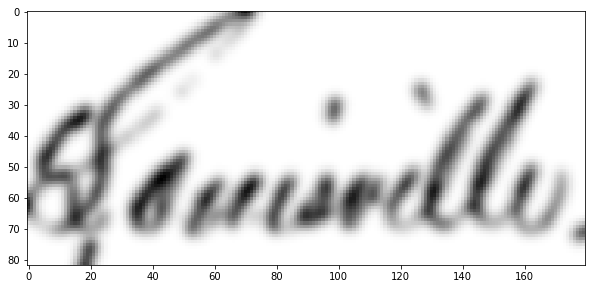

In [7]:
# for i in range(1, len(lb)):
i=2
#     print(i, end=" ")
# if matches[i] == -1:
#     continue
rw = linesForTele.loc[matches[i],"consensus_text"]
# remove leading and trailing "
if rw[0] == '"':
    rw = rw[1:]
if rw[-1] == '"':
    rw = rw[:-1]
wb = accur.loc[accur['lb_index'] == i, 'breaks'].iloc[0]

#     for j in range(1, len(wb)):
j=1
chunk = grey[lb[i-1]:lb[i], wb[j-1]:wb[j]]
plt.imshow(chunk, cmap='gray')
plt.show()

chunkBi, _ = binarizeImg(chunk, skimfilt.threshold_otsu)
plt.imshow(chunkBi, cmap='gray')
plt.show()

chunkSm = smoothImg(chunkBi, 2)
plt.imshow(chunkSm, cmap='gray')
plt.show()
# break
# break

# Ignore after this

In [25]:
from scipy.interpolate import interp2d
# def projAngle(data, m, startx):
data = chunk
m = slope
startx = 175
nrow, ncol = data.shape
x = np.arange(ncol)
y = np.arange(nrow)
f = interp2d(x, y, data)

# get points from slope
starty = 0
endy = nrow
endx = m*(endy-starty) + startx

In [33]:
# extract values on line from r1, c1 to r2, c2
num_points = nrow
xvalues = np.linspace(startx, endx, num_points)
yvalues = np.linspace(starty, endy, num_points)
zvalues = np.diag(f(xvalues, yvalues))

In [34]:
zvalues

array([ 0.83358565,  0.83266634,  0.8325511 ,  0.83386707,  0.84611609,
        0.89642197,  0.88046276,  0.35553299,  0.76455478,  0.8560043 ,
        0.90525962,  0.659649  ,  0.82246372,  0.83389312,  0.84550132,
        0.83263396,  0.83380588,  0.83438992,  0.83658863,  0.83658863,
        0.83658863,  0.83658863,  0.83658863,  0.83658863,  0.83658863,
        0.83770582,  0.83827748,  0.83266706,  0.83574551,  0.8405102 ,
        0.81224693,  0.88453863,  0.89144949,  0.17679517,  0.75199935,
        0.86170075,  0.85305259,  0.84536527,  0.83980927,  0.83772745,
        0.84596635,  0.8060258 ,  0.75565557,  0.84288757,  0.84492519,
        0.84536472,  0.84434047,  0.84619998,  0.85783251,  0.86712584,
        0.43807212,  0.91865294,  0.91730045,  0.47184145,  0.48125029,
        0.43788085,  0.92791628,  0.85506843,  0.86441447,  0.86453591,
        0.88177314,  0.20298528,  0.1799027 ,  0.78603261,  0.89251136,
        0.84140695,  0.67271472,  0.70334027,  0.84356751,  0.84

In [31]:
zvalues[0,:]

array([ 0.83358565,  0.83266706,  0.83266706,  0.83266706,  0.83266706,
        0.82951054,  0.83036408,  0.84059087,  0.8493604 ,  0.85619647,
        0.84806832,  0.85849183,  0.9080687 ,  0.82181436,  0.55882036,
        0.48445914,  0.44819702,  0.40937492,  0.79338321,  0.85106145,
        0.83763922,  0.83324039,  0.83324039,  0.83324039,  0.83324039,
        0.83324039,  0.83324039,  0.83324039,  0.83324039,  0.83324039,
        0.83210157,  0.83210157,  0.83210157,  0.83210157,  0.83210157,
        0.83772745,  0.83772745,  0.83380588,  0.83042037,  0.82988431,
        0.83093895,  0.82117056,  0.77470383,  0.82752632,  0.83859598,
        0.83555994,  0.82925472,  0.82294951,  0.82033686,  0.82425843,
        0.82033686,  0.82333724,  0.82572089,  0.82818   ,  0.83210157,
        0.82895026,  0.83210157,  0.83602314,  0.83994471,  0.84240642,
        0.83210157,  0.83210157,  0.83210157,  0.83210157,  0.83210157,
        0.83602314,  0.83602314,  0.83602314,  0.83602314,  0.83

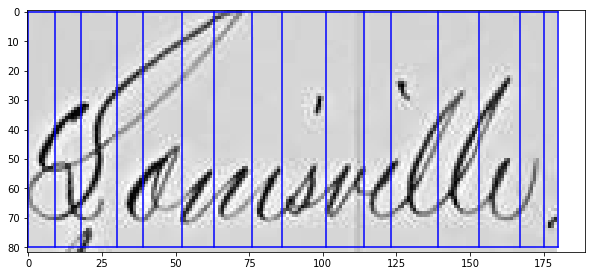

array([  0,   9,  18,  30,  39,  52,  63,  76,  86, 101, 114, 123, 139,
       153, 167, 175, 180])

In [48]:
cb = projBreaks(chunkSm, 'x')
plotBoxes(chunk, lb = [0, 80], wb = [cb], cmap = 'gray')
cb

In [ ]:
#         save object
# with open(savefile, "wb") as f:
#     pickle.dump(data, f)

mssEC_02_007
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
mssEC_02_008
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
mssEC_02_009
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
mssEC_02_010
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
mssEC_02_011
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
mssEC_02_012
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 
mssEC_02_013
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 
mssEC_02_014
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
mssEC_02_015
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 
mssEC_02_016
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

In [39]:
print(idAndUrl.loc[im, "url_cons"])

https://panoptes-uploads.zooniverse.org/production/subject_location/088bb5aa-7265-4246-a784-59d1ad1793ee.jpeg
